In [1]:
%run "../HyperParameterOpt/GenerateExperiments/res_experiment.py"
from scipy import sparse
import networkx as nx
from matplotlib import pyplot as plt

# Notation Explanation Plots

A notebook of plots to help explain $\mathbf{u}(t)$, $\mathbf{\hat{u}}(t)$, $\mathbf{r}(t)$, the processing network and the aggregate network.

### Parameters

In [11]:
DIFF_EQ_PARAMS = {
    "x0": [-20, 10, -.5],
    "begin": 0,
    "end": 85,
    "timesteps": 85000,
    "train_per": .889,
    "solver": lorenz_equ,
    "clip": 40
}
RES_PARAMS = {
    "uniform_weights": True,
    "solver": "ridge",
    "ridge_alpha":.0001,
    "signal_dim": 3,
    "network": "random graph",
    "res_sz": 50,
    "activ_f": np.tanh,
    "connect_p": .1,
    "spect_rad": 50,
    "gamma": 5,
    "sigma": 0.05,
    "sparse_res": True,
}

### Functions

In [157]:
def erdos(mean_degree,n=None):
    """ Erdos-Renyi random graph.
    Parameter
        mean_degree     (int): specific to this topology
        n               (int): n is the size of the network
    """
    if n is None:
        n = np.random.randint(smallest_network_size,biggest_network_size)
    p = mean_degree/n
    A = nx.adj_matrix(nx.erdos_renyi_graph(n,p)).T
    return sparse.dok_matrix(A)

def remove_edges(A, p):
    """ Randomly removes 'p' percent of edges from a sparse matrix 'A'
    """
    nedges = floor(p*np.sum(A != 0))
    A = A.todok()
    # Remove Edges
    keys = list(A.keys())
    remove_idx = np.random.choice(range(len(keys)),size=nedges, replace=False)
    remove = [keys[i] for i in remove_idx]
    for e in remove:
        A[e] = 0
    return A

def notation_expl(rc, R, U, Uhat, test_t):
    acc_dur = how_long_accurate(U, Uhat, tol=TOL)
    # Node colors
    nc = np.random.rand(rc.res_sz, 3)
    titlesz = 14
    f = plt.figure()
    plt.GridSpec(2,4)
    
    plt.subplot2grid((2,4), (0,3), colspan=1, rowspan=1)
    plt.title("Processing Network", fontsize=titlesz)
    nx.draw_spring(nx.DiGraph(rc.res), node_color=nc, node_size=60, arrows=False)

    plt.subplot2grid((2,4), (0,0), colspan=3, rowspan=1)
    plt.title("Processing Network Response $\\mathbf{r}(t)$", fontsize=titlesz)
    for i in range(n):
        plt.plot(train_t, R[:, i], c=nc[i])
    plt.yticks([-1, 1])
    plt.ylabel("Reservoir Node States")
    tks = np.arange(40, 90, 10)
    plt.xticks(tks, tks - 40)

    plt.subplot2grid((2,4), (1,3), colspan=1, rowspan=1)
    plt.title("Aggregate Network", fontsize=titlesz)
    aggA = np.array(rc.res + rc.sigma*rc.W_in @ rc.W_out)
    G = nx.DiGraph(aggA)
    labels = nx.get_edge_attributes(G,'weight')
    eweights = np.log([np.abs(labels[e]) + 1.0 for e in G.edges()])
    eweights /= np.max(eweights)
    #eweights = 1 - eweights
    ecolors = np.vstack((eweights, eweights, eweights)).T
    nx.draw_spring(G, edge_color=ecolors, node_color="teal", node_size=60, arrows=False)

    plt.subplot2grid((2,4), (1,0), colspan=3, rowspan=1)
    plt.title("Aggregate Network Prediction $\\mathbf{\\hat{u}}(t)$", fontsize=titlesz)
    ymax = np.max([np.max(Uhat), np.max(U)])
    ymin = np.min([np.min(Uhat), np.min(U)])
    plt.plot(test_t, U.T, "gray")
    plt.plot(test_t[0], U.T[0,0], "gray", label="True: $\\mathbf{u}(t)$")
    plt.plot(test_t, Uhat.T, "teal")
    plt.plot(test_t[0], Uhat.T[0,0], "teal", label="Predicted: $\\mathbf{\\hat{u}}(t)$")
    plt.plot(np.ones(10)*test_t[acc_dur], np.linspace(ymin, ymax, 10), "--", c="r")
    plt.xlabel("Time (s)")
    plt.ylabel("Lorenz Attractor")
    ts_tks = np.arange(80, 86, 1)
    plt.yticks([np.round(ymin), np.round(ymax)])
    plt.xticks(ts_tks, ts_tks - 40)
    locs, labels = plt.xticks()
    plt.xticks(list(locs) + [test_t[acc_dur]], list(labels) + ["VPT"])
    plt.legend(loc=(0.83, .6))
    
    plt.tight_layout()
    return f

In [141]:
DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)

In [164]:
plt.rcParams["figure.figsize"] = [15,5]
rho = 5
mean_degree = 4
remove_p = 0.0

n = RES_PARAMS["res_sz"]
RES_PARAMS["spect_rad"] = rho
A = remove_edges(erdos(mean_degree, n), remove_p)
A = sparse.lil_matrix(A)

In [165]:
rc = ResComp(A, **RES_PARAMS)
rc.state_0 = 2*np.random.rand(rc.res_sz) - 1
r0 = rc.state_0
err, R = rc.fit(train_t, u, return_states=True)
U = u(test_t)
Uhat = rc.predict(test_t)
acc_dur = how_long_accurate(U, Uhat, tol=TOL)
print(f"VPT: {acc_dur}")

VPT: 341


# Notes
Aggregate network teal nodes, invert edge color, rerun with different gammas, print vpt

3x3 Figure--Add network topologies along axis, keep it undirected, get the parameters

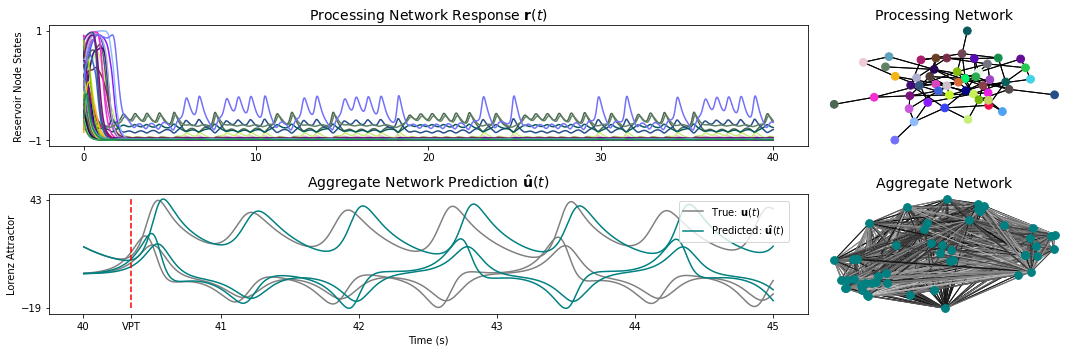

In [166]:
notation_expl(rc, R, U, Uhat, test_t)
plt.savefig("two_networks_dense.png", dpi=300)

In [172]:
rho = 5
mean_degree = 4
remove_p = 0.9

n = RES_PARAMS["res_sz"]
RES_PARAMS["spect_rad"] = rho
A = remove_edges(erdos(mean_degree, n), remove_p)
A = sparse.lil_matrix(A)
rc = ResComp(A, **RES_PARAMS)
rc.state_0 = 2*np.random.rand(rc.res_sz) - 1
r0 = rc.state_0
err, R = rc.fit(train_t, u, return_states=True)
U = u(test_t)
Uhat = rc.predict(test_t)
acc_dur = how_long_accurate(U, Uhat, tol=TOL)
print(f"VPT: {acc_dur}")

VPT: 3341


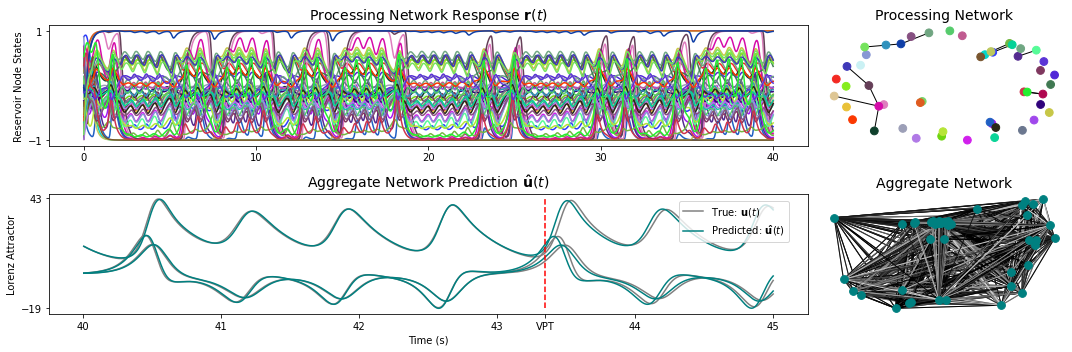

In [173]:
notation_expl(rc, R, U, Uhat, test_t)
plt.savefig("two_networks_thin.png", dpi=300)

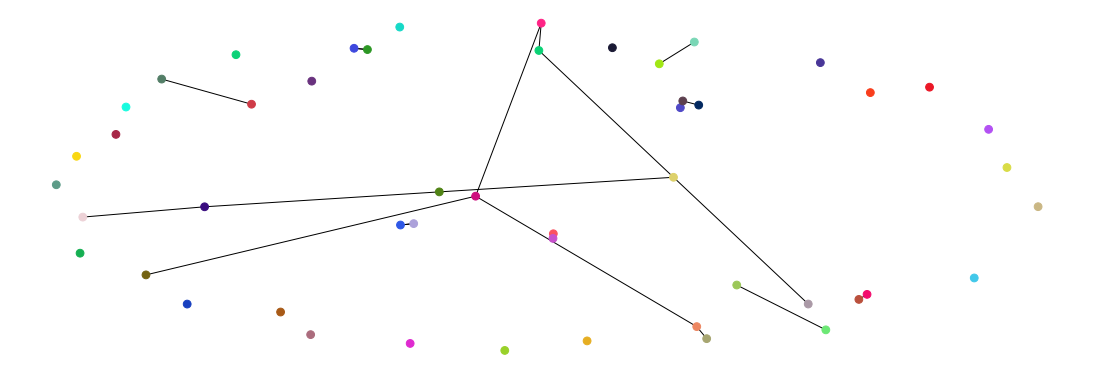

In [26]:
nc = np.random.rand(n, 3)
nx.draw_spring(nx.DiGraph(rc.res), node_color=nc, node_size=60, arrows=False)

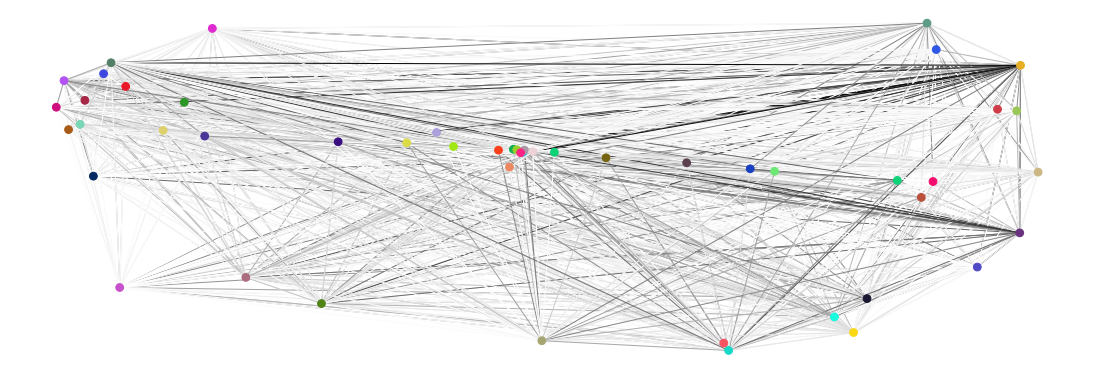

In [27]:
aggA = np.array(rc.res + rc.sigma*rc.W_in @ rc.W_out)
G = nx.DiGraph(aggA)
labels = nx.get_edge_attributes(G,'weight')
eweights = [np.abs(labels[e]) for e in G.edges()]
eweights /= np.max(eweights)
eweights = 1 - eweights
ecolors = np.vstack((eweights, eweights, eweights)).T
nx.draw_spring(G, edge_color=ecolors, node_color=nc, node_size=60, arrows=False)

In [96]:
def knngraph(A, k):
    n, _ = A.shape
    G = nx.DiGraph()
    for i, ai in enumerate(A):
        nearestnodes = np.argsort(ai)[::-1]
        for j in range(k):
            neighbor = nearestnodes[j]
            G.add_edge(neighbor, i, weight=A[i, neighbor])
    return G       

In [92]:
np.argsort(aggA[0])

array([ 4, 21,  8, 10, 17,  0, 20, 36, 48, 38,  5, 19, 14, 29, 40, 16, 26,
       23, 46, 11, 31, 45, 37, 42, 49, 22, 13, 32, 30,  7, 24, 27, 35,  1,
       28, 18,  3, 47, 12, 34, 39,  2, 41,  9,  6, 15, 43, 33, 44, 25])

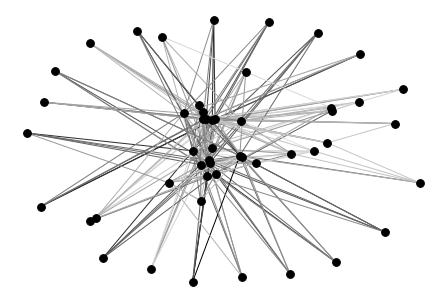

In [104]:
knnG = knngraph(aggA, 5)
labels = nx.get_edge_attributes(knnG,'weight')
eweights = [np.abs(labels[e]) for e in knnG.edges()]
eweights /= np.max(eweights)
eweights = 1 - eweights
ecolors = np.vstack((eweights, eweights, eweights)).T
nx.draw_spring(knnG, edge_color=ecolors, node_color="k", node_size=60, arrows=False)